# Model Predictive Control for Tank Drive Robot

This notebook demonstrates Model Predictive Control (MPC) for trajectory tracking with the tank drive robot, comparing it against an LQR baseline.

## What is MPC?

MPC is a control strategy that:

1. Predicts future system behavior over a finite time horizon using a dynamics model
1. Optimizes a sequence of future control inputs to minimize a cost function
1. Applies only the first control input, then re-plans at the next timestep (receding horizon)

### Key Advantages over LQR

1. Can handle constraints on inputs and states explicitly
1. Uses preview information about the reference trajectory
1. Can work with nonlinear dynamics directly (nonlinear MPC)

### Key Disadvantages

- **Computationally expensive** - solves optimization at each timestep
- **Tuning complexity** - more parameters (horizons, weights, solver settings)
- **No stability guarantees** for general nonlinear systems

## Architecture Overview

```
Reference Trajectory ──┐
                       │
                       ▼
              ┌─────────────────┐
              │   MPC Solver    │
              │  ┌───────────┐  │
State ──────> │  │ Predict   │  │──────> Control
Estimate      │  │ N steps   │  │        (first input only)
              │  └───────────┘  │
              │  ┌───────────┐  │
              │  │ Minimize  │  │
              │  │ Cost J    │  │
              │  └───────────┘  │
              └─────────────────┘
```

## Imports

In [ ]:
import sys
sys.path.insert(0, "..")  # Add parent directory for module imports

import numpy as np
import matplotlib.pyplot as plt
import importlib

from kalman import KalmanFilter
from lqr_controller import SwitchingLQRController
import control as ctl
import mpc_controller
importlib.reload(mpc_controller)
from mpc_controller import LinearMPC, NonlinearMPC, LinearTimeVaryingMPC, state_error, angle_wrap
from simulation import TankDriveSimulation, discretize_system

## Parameters

In [42]:
# Physical parameters
L = 0.14      # wheelbase [m]
tau = 0.2     # wheel speed time constant [s]

# State: [x, y, theta, v_l, v_r]
n_states = 5
n_inputs = 2
n_outputs = 6   # [x, y, theta, theta_dot, v_l, v_r] - added position measurements!

# Simulation parameters
T_final = 30.0
dt = 0.05   # 20 Hz control (typical for MPC)
N = int(T_final / dt)
t = np.arange(N) * dt

# Noise covariances
Q = np.diag([1e-5, 1e-5, 1e-6, 1e-4, 1e-4])  # process noise

# Measurement noise - position measurements are noisier than encoders
# Simulates GPS/vision localization (~5cm accuracy) + IMU/encoders
R = np.diag([
    0.05**2,   # x position (GPS/vision) - 5cm std dev
    0.05**2,   # y position (GPS/vision) - 5cm std dev  
    1e-3,      # theta (magnetometer)
    1e-2,      # theta_dot (gyro)
    1e-3,      # v_l (encoder)
    1e-3       # v_r (encoder)
])

# Control parameters
v0 = 0.25  # linearization point
u_max = 0.5  # maximum wheel speed command [m/s]

# MPC parameters
N_horizon = 10  # prediction horizon (10 steps = 0.5s at 20Hz)
N_control = 5   # control horizon (only optimize first 5 moves)

# MPC cost weights
Q_mpc = np.diag([20.0, 20.0, 0.5, 0.1, 0.1])  # state tracking weight
R_mpc = np.diag([1.0, 1.0])  # control effort weight
Q_terminal = Q_mpc * 2  # terminal state weight

# LQR weights (for comparison) - also reduced heading weight
Q_lqr = np.diag([20.0, 20.0, 0.5, 0.1, 0.1])
R_lqr = np.diag([1.0, 1.0])

# Waypoint trajectory
waypoints = np.array([
    [0.0, 0.0],
    [3.0, 3.0],
    [6.0, 2.0],
    [8.0, 5.0],
    [8.0, 5.0]  # Stay at final point
])

print(f"Control frequency: {1/dt:.1f} Hz")
print(f"Prediction horizon: {N_horizon} steps ({N_horizon*dt:.2f}s)")
print(f"Control horizon: {N_control} steps ({N_control*dt:.2f}s)")
print(f"Measurements: x, y (GPS/vision), theta (mag), theta_dot (gyro), v_l, v_r (encoders)")

Control frequency: 20.0 Hz
Prediction horizon: 10 steps (0.50s)
Control horizon: 5 steps (0.25s)
Measurements: x, y (GPS/vision), theta (mag), theta_dot (gyro), v_l, v_r (encoders)


## System Dynamics

### Nonlinear Model

$$\dot{x} = \frac{v_l + v_r}{2} \cos(\theta)$$
$$\dot{y} = \frac{v_l + v_r}{2} \sin(\theta)$$
$$\dot{\theta} = \frac{v_r - v_l}{L}$$
$$\dot{v}_l = -\frac{1}{\tau}v_l + \frac{1}{\tau}u_l$$
$$\dot{v}_r = -\frac{1}{\tau}v_r + \frac{1}{\tau}u_r$$

In [43]:
def nonlinear_dynamics(x, u, dt_step, L, tau):
    """
    Propagate state forward using nonlinear tank drive dynamics.
    
    Uses Euler integration for simplicity. State is [x, y, theta, v_l, v_r]
    where v_l and v_r are left/right wheel velocities with first-order
    dynamics (time constant tau).
    
    Args:
        x: State vector [x, y, theta, v_l, v_r]
        u: Control input [u_l, u_r] - commanded wheel speeds
        dt_step: Time step [s]
        L: Wheelbase [m]
        tau: Wheel speed time constant [s]
    
    Returns:
        x_next: Next state vector
    """
    x_pos, y_pos, theta, v_l, v_r = x
    u_l, u_r = u
    
    # Average velocity and turn rate
    v_avg = (v_l + v_r) / 2.0
    
    # State derivatives
    x_dot = v_avg * np.cos(theta)
    y_dot = v_avg * np.sin(theta)
    theta_dot = (v_r - v_l) / L
    v_l_dot = (-v_l + u_l) / tau
    v_r_dot = (-v_r + u_r) / tau
    
    # Euler integration
    x_next = np.array([
        x_pos + x_dot * dt_step,
        y_pos + y_dot * dt_step,
        theta + theta_dot * dt_step,
        v_l + v_l_dot * dt_step,
        v_r + v_r_dot * dt_step
    ])
    
    return x_next


def compute_jacobian(x, dt_step, L, tau):
    """
    Compute Jacobian of nonlinear dynamics at state x.
    
    Used for Extended Kalman Filter linearization.
    
    Args:
        x: State [x, y, theta, v_l, v_r]
        dt_step: Time step [s]
        L: Wheelbase [m]
        tau: Wheel speed time constant [s]
    
    Returns:
        F: State transition Jacobian (5x5)
    """
    x_pos, y_pos, theta, v_l, v_r = x
    v_avg = (v_l + v_r) / 2.0
    
    F = np.eye(5)
    F[0, 2] = -v_avg * np.sin(theta) * dt_step
    F[0, 3] = 0.5 * np.cos(theta) * dt_step
    F[0, 4] = 0.5 * np.cos(theta) * dt_step
    F[1, 2] = v_avg * np.cos(theta) * dt_step
    F[1, 3] = 0.5 * np.sin(theta) * dt_step
    F[1, 4] = 0.5 * np.sin(theta) * dt_step
    F[2, 3] = -dt_step / L
    F[2, 4] = dt_step / L
    F[3, 3] = 1.0 - dt_step / tau
    F[4, 4] = 1.0 - dt_step / tau
    
    return F

## Linearized System

Linearization around $(x, y, \theta, v_l, v_r) = (0, 0, 0, v_0, v_0)$

In [44]:
# Continuous-time linearized system
A = np.array([
    [0, 0,   0,      0.5,   0.5],
    [0, 0,   0.5*v0,  0.0,   0.0],
    [0, 0,   0,     -1/L,   1/L],
    [0, 0,   0,  -1.0/tau,  0.0],
    [0, 0,   0,      0.0, -1.0/tau],
])

B = np.array([
    [0.0,      0.0],
    [0.0,      0.0],
    [0.0,      0.0],
    [1.0/tau,  0.0],
    [0.0,  1.0/tau],
])

# Measurement model - now includes position measurements!
# y = [x, y, theta, theta_dot, v_l, v_r]
C = np.array([
    [1, 0, 0,     0,    0],      # GPS/vision: x position
    [0, 1, 0,     0,    0],      # GPS/vision: y position
    [0, 0, 1,     0,    0],      # magnetometer: theta
    [0, 0, 0, -1/L, 1/L],        # gyro: theta_dot = (v_r - v_l) / L
    [0, 0, 0,     1,    0],      # left encoder: v_l
    [0, 0, 0,     0,    1],      # right encoder: v_r
])
D = np.zeros((n_outputs, n_inputs))

# Discretize
Ad, Bd, Cd, Dd = discretize_system(A, B, C, D, dt)

print("Discrete-time system matrices computed.")
print(f"State dimension: {n_states}")
print(f"Measurement dimension: {n_outputs} (x, y, theta, theta_dot, v_l, v_r)")

Discrete-time system matrices computed.
State dimension: 5
Measurement dimension: 6 (x, y, theta, theta_dot, v_l, v_r)


## Reference Trajectory Generation


Generate a smooth reference trajectory through the waypoints.

/tmp/ipykernel_35959/1399291363.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  tau_seg = (t[k] - segment_start_time) / segment_times[current_segment]


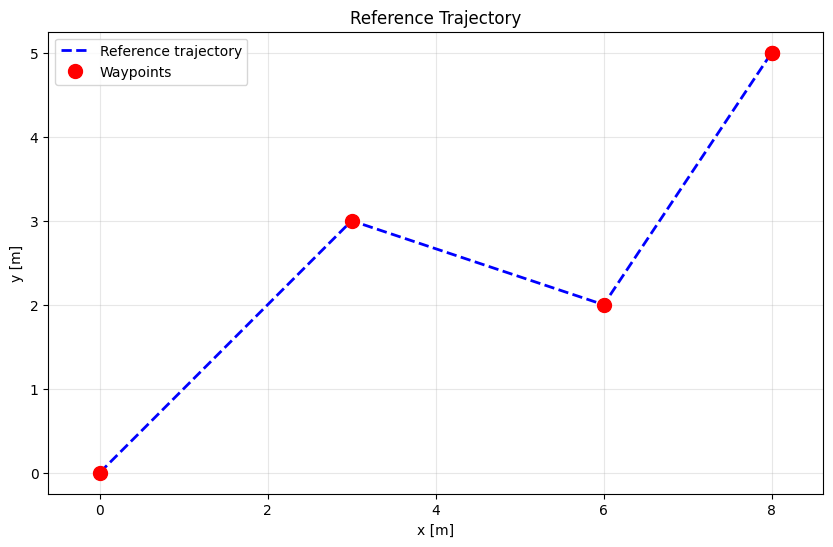

In [45]:
def generate_reference_trajectory(waypoints, t, v_cruise=0.5):
    """
    Generate reference trajectory through waypoints.
    
    Args:
        waypoints: Nx2 array of [x, y] positions
        t: Time vector
        v_cruise: Desired cruise speed [m/s]
    
    Returns:
        x_ref: 5xN reference state trajectory
    """
    N = len(t)
    x_ref = np.zeros((5, N))
    
    # Compute segment lengths
    segment_lengths = []
    for i in range(len(waypoints) - 1):
        length = np.linalg.norm(waypoints[i+1] - waypoints[i])
        segment_lengths.append(length)
    
    total_length = sum(segment_lengths)
    segment_times = [length / v_cruise for length in segment_lengths]
    
    # Generate trajectory
    current_segment = 0
    segment_start_time = 0
    
    for k in range(N):
        # Find current segment
        while (current_segment < len(segment_times) - 1 and 
               t[k] > segment_start_time + segment_times[current_segment]):
            segment_start_time += segment_times[current_segment]
            current_segment += 1
        
        if current_segment >= len(segment_times):
            # At final waypoint
            x_ref[0, k] = waypoints[-1, 0]
            x_ref[1, k] = waypoints[-1, 1]
            x_ref[2, k] = 0.0
            x_ref[3, k] = 0.0
            x_ref[4, k] = 0.0
        else:
            # Interpolate along segment
            tau_seg = (t[k] - segment_start_time) / segment_times[current_segment]
            tau_seg = np.clip(tau_seg, 0, 1)
            
            p0 = waypoints[current_segment]
            p1 = waypoints[current_segment + 1]
            
            # Position
            pos = p0 + tau_seg * (p1 - p0)
            x_ref[0, k] = pos[0]
            x_ref[1, k] = pos[1]
            
            # Heading (point toward next waypoint)
            dx = p1[0] - p0[0]
            dy = p1[1] - p0[1]
            x_ref[2, k] = np.arctan2(dy, dx)
            
            # Wheel speeds for cruise velocity
            x_ref[3, k] = v_cruise
            x_ref[4, k] = v_cruise
    
    return x_ref

# Generate reference
x_ref_traj = generate_reference_trajectory(waypoints, t, v_cruise=0.5)

# Plot reference trajectory
plt.figure(figsize=(10, 6))
plt.plot(x_ref_traj[0, :], x_ref_traj[1, :], 'b--', linewidth=2, label='Reference trajectory')
plt.plot(waypoints[:, 0], waypoints[:, 1], 'ro', markersize=10, label='Waypoints')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Reference Trajectory')
plt.show()


## MPC Controller Implementation

### The Optimization Problem

At each timestep $k$, MPC solves:

$$\min_{\mathbf{u}_0, \ldots, \mathbf{u}_{N_c-1}} J = \sum_{i=0}^{N_h-1} \left[ \mathbf{e}_i^T Q \mathbf{e}_i + \mathbf{u}_i^T R \mathbf{u}_i \right] + \mathbf{e}_{N_h}^T Q_f \mathbf{e}_{N_h}$$

Where:
- $\mathbf{e}_i = \mathbf{x}_i - \mathbf{x}_{ref,i}$ is the tracking error at step $i$
- $N_h$ = prediction horizon (how far ahead we predict)
- $N_c$ = control horizon (how many controls we optimize, $N_c \leq N_h$)
- For $i \geq N_c$, we hold $\mathbf{u}_i = \mathbf{u}_{N_c-1}$ (reduces optimization variables)

### Subject to Constraints

- **Dynamics:** $\mathbf{x}_{i+1} = f(\mathbf{x}_i, \mathbf{u}_i)$ (linear or nonlinear)
- **Input bounds:** $-u_{max} \leq u_l, u_r \leq u_{max}$

### Implementation Details

| Parameter | Value | Meaning |
|-----------|-------|---------|
| $N_h$ | 10 steps | 0.5s lookahead at 20 Hz |
| $N_c$ | 5 steps | Optimize 0.25s of control inputs |
| $u_{max}$ | 2.0 m/s | Wheel speed command limit |
| Optimizer | SLSQP | Sequential Least Squares Programming |

### Two Implementations

1. **LinearMPC**: Uses linearized discrete dynamics $\mathbf{x}_{k+1} = A_d \mathbf{x}_k + B_d \mathbf{u}_k$
   - Faster prediction (matrix multiplication)
   - Less accurate for large deviations from linearization point

2. **NonlinearMPC**: Uses full nonlinear dynamics via `nonlinear_dynamics()`
   - More accurate predictions
   - Slower (numerical integration at each prediction step)
   - Optimization landscape may have local minima

In [46]:
# MPC controllers are imported from mpc_controller.py
# See that module for implementation details

print("LinearMPC and NonlinearMPC imported from mpc_controller.py")
print(f"  - LinearMPC: Uses discrete-time linear dynamics (Ad, Bd)")
print(f"  - NonlinearMPC: Uses full nonlinear tank drive dynamics")

LinearMPC and NonlinearMPC imported from mpc_controller.py
  - LinearMPC: Uses discrete-time linear dynamics (Ad, Bd)
  - NonlinearMPC: Uses full nonlinear tank drive dynamics


## Simulations

We compare three controllers on the same waypoint tracking task:

| Controller | Dynamics Model | Preview | Notes |
|------------|---------------|---------|-------|
| **LQR** | Linearized | None | Baseline - reacts only to current error |
| **Linear MPC** | Linearized | 0.5s | Uses reference preview, linear prediction |
| **Nonlinear MPC** | Full nonlinear | 0.5s | Full model in prediction |

### Simulation Setup
- **True plant**: Always nonlinear dynamics (what actually happens)
- **State estimation**: Kalman filter (same for all controllers)
- **Noise**: Same random seed for fair comparison
- **Trajectory**: Waypoints at (0,0) → (3,3) → (6,2) → (8,5)

---

## Simulation 1: LQR Baseline

LQR computes control as $\mathbf{u} = -K(\hat{\mathbf{x}} - \mathbf{x}_{ref})$ where $K$ is the optimal gain matrix.

**No preview** - only uses current reference point, not future trajectory.

In [47]:
# Initial conditions
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
P_init = np.eye(n_states) * 0.1

# Initialize Kalman Filter
kf_lqr = KalmanFilter(Ad, Bd, Cd, Q, R, x0=x0, P0=P_init)

# LQR gain matrix
K_lqr = np.array(ctl.dlqr(Ad, Bd, Q_lqr, R_lqr)[0])

# Storage
x_true_lqr = np.zeros((n_states, N))
x_hat_lqr = np.zeros((n_states, N))
u_lqr = np.zeros((N, n_inputs))

x_true_lqr[:, 0] = x0
x_hat_lqr[:, 0] = x0

# Noise
Q_chol = np.linalg.cholesky(Q)
R_chol = np.linalg.cholesky(R)
rng_lqr = np.random.default_rng(42)

print("Running LQR simulation...")
for k in range(N - 1):
    # Measurement
    v_k = R_chol @ rng_lqr.standard_normal(n_outputs)
    y_k = Cd @ x_true_lqr[:, k] + v_k
    
    # Kalman filter
    if k > 0:
        kf_lqr.predict(u_lqr[k-1, :])
    kf_lqr.update(y_k)
    x_hat_lqr[:, k] = kf_lqr.get_state()
    
    # LQR control with proper angle wrapping
    x_error = state_error(x_hat_lqr[:, k], x_ref_traj[:, k])
    u_lqr[k, :] = -K_lqr @ x_error
    u_lqr[k, :] = np.clip(u_lqr[k, :], -u_max, u_max)
    
    # True system (nonlinear)
    w_k = Q_chol @ rng_lqr.standard_normal(n_states)
    x_true_lqr[:, k+1] = nonlinear_dynamics(x_true_lqr[:, k], u_lqr[k, :], dt, L, tau) + w_k

# Final step
kf_lqr.predict(u_lqr[-2, :])
y_k = Cd @ x_true_lqr[:, -1] + R_chol @ rng_lqr.standard_normal(n_outputs)
kf_lqr.update(y_k)
x_hat_lqr[:, -1] = kf_lqr.get_state()

print("LQR simulation complete!")

Running LQR simulation...
LQR simulation complete!
LQR simulation complete!


## Simulation 2: Linear MPC

Uses linearized dynamics $\mathbf{x}_{k+1} = A_d \mathbf{x}_k + B_d \mathbf{u}_k$ for prediction.

**Has preview** - optimizes over future reference trajectory, but model may be inaccurate when far from the linearization point $(x, y, \theta, v_l, v_r) = (0, 0, 0, v_0, v_0)$.

In [48]:
# Initialize Linear MPC
mpc_linear = LinearMPC(Ad, Bd, Q_mpc, R_mpc, Q_terminal, N_horizon, N_control, u_max, dt)

# Initialize Kalman Filter
kf_mpc_lin = KalmanFilter(Ad, Bd, Cd, Q, R, x0=x0, P0=P_init)

# Storage
x_true_mpc_lin = np.zeros((n_states, N))
x_hat_mpc_lin = np.zeros((n_states, N))
u_mpc_lin = np.zeros((N, n_inputs))

x_true_mpc_lin[:, 0] = x0
x_hat_mpc_lin[:, 0] = x0

# Noise (same seed for fair comparison)
rng_mpc_lin = np.random.default_rng(42)

print("Running Linear MPC simulation...")
for k in range(N - 1):
    # Measurement
    v_k = R_chol @ rng_mpc_lin.standard_normal(n_outputs)
    y_k = Cd @ x_true_mpc_lin[:, k] + v_k
    
    # Kalman filter
    if k > 0:
        kf_mpc_lin.predict(u_mpc_lin[k-1, :])
    kf_mpc_lin.update(y_k)
    x_hat_mpc_lin[:, k] = kf_mpc_lin.get_state()
    
    # MPC control - need N_horizon+1 reference points for terminal cost
    k_end = min(k + N_horizon + 1, N)
    x_ref_horizon = x_ref_traj[:, k:k_end]
    
    # Pad if necessary to get N_horizon+1 points
    if x_ref_horizon.shape[1] < N_horizon + 1:
        pad_width = N_horizon + 1 - x_ref_horizon.shape[1]
        x_ref_horizon = np.hstack([x_ref_horizon, 
                                   np.tile(x_ref_traj[:, -1:], (1, pad_width))])
    
    u_mpc_lin[k, :] = mpc_linear.compute_control(x_hat_mpc_lin[:, k], x_ref_horizon)
    
    # True system (nonlinear)
    w_k = Q_chol @ rng_mpc_lin.standard_normal(n_states)
    x_true_mpc_lin[:, k+1] = nonlinear_dynamics(x_true_mpc_lin[:, k], u_mpc_lin[k, :], dt, L, tau) + w_k
    
    if (k+1) % 100 == 0:
        print(f"  Step {k+1}/{N}")

# Final step
kf_mpc_lin.predict(u_mpc_lin[-2, :])
y_k = Cd @ x_true_mpc_lin[:, -1] + R_chol @ rng_mpc_lin.standard_normal(n_outputs)
kf_mpc_lin.update(y_k)
x_hat_mpc_lin[:, -1] = kf_mpc_lin.get_state()

print("Linear MPC simulation complete!")

Running Linear MPC simulation...
  Step 100/600
  Step 200/600
  Step 300/600
  Step 100/600
  Step 200/600
  Step 300/600
  Step 400/600
  Step 500/600
Linear MPC simulation complete!
  Step 400/600
  Step 500/600
Linear MPC simulation complete!


## Simulation 3: Linear Time-Varying MPC

The issue with fixed-linearization MPC is that the Jacobian depends on the operating point. Specifically:

$$\dot{x} = \cos(\theta) \cdot v_{avg}, \quad \dot{y} = \sin(\theta) \cdot v_{avg}$$

When linearized around $\theta = 0$:
- $\partial\dot{x}/\partial\theta = -\sin(0) \cdot v_0 = 0$
- $\partial\dot{y}/\partial\theta = \cos(0) \cdot v_0 = v_0$

This means $\dot{y} \approx v_0 \cdot \theta$, which is only valid when $\theta \approx 0$!

**LTV-MPC Solution**: Re-linearize the dynamics around the *reference trajectory* at each prediction step, creating time-varying $A_k$, $B_k$ matrices that correctly capture how heading changes affect position.

In [53]:
# Initialize LTV-MPC
mpc_ltv = LinearTimeVaryingMPC(L, tau, dt, N_horizon, N_control, Q_mpc, u_max)

# Initialize Kalman Filter
kf_mpc_ltv = KalmanFilter(Ad, Bd, Cd, Q, R, x0=x0, P0=P_init)

# Storage
x_true_mpc_ltv = np.zeros((n_states, N))
x_hat_mpc_ltv = np.zeros((n_states, N))
u_mpc_ltv = np.zeros((N, n_inputs))

x_true_mpc_ltv[:, 0] = x0
x_hat_mpc_ltv[:, 0] = x0

# Noise (same seed for fair comparison)
rng_mpc_ltv = np.random.default_rng(42)

print("Running LTV-MPC simulation...")
for k in range(N - 1):
    # Measurement
    v_k = R_chol @ rng_mpc_ltv.standard_normal(n_outputs)
    y_k = Cd @ x_true_mpc_ltv[:, k] + v_k
    
    # Kalman filter
    if k > 0:
        kf_mpc_ltv.predict(u_mpc_ltv[k-1, :])
    kf_mpc_ltv.update(y_k)
    x_hat_mpc_ltv[:, k] = kf_mpc_ltv.get_state()
    
    # MPC control - need N_horizon+1 reference points for terminal cost
    k_end = min(k + N_horizon + 1, N)
    x_ref_horizon = x_ref_traj[:, k:k_end]
    
    # Pad if necessary to get N_horizon+1 points
    if x_ref_horizon.shape[1] < N_horizon + 1:
        pad_width = N_horizon + 1 - x_ref_horizon.shape[1]
        x_ref_horizon = np.hstack([x_ref_horizon, 
                                   np.tile(x_ref_traj[:, -1:], (1, pad_width))])
    
    u_mpc_ltv[k, :] = mpc_ltv.compute_control(x_hat_mpc_ltv[:, k], x_ref_horizon)
    
    # True system (nonlinear)
    w_k = Q_chol @ rng_mpc_ltv.standard_normal(n_states)
    x_true_mpc_ltv[:, k+1] = nonlinear_dynamics(x_true_mpc_ltv[:, k], u_mpc_ltv[k, :], dt, L, tau) + w_k
    
    if (k+1) % 100 == 0:
        print(f"  Step {k+1}/{N}")

# Final step
kf_mpc_ltv.predict(u_mpc_ltv[-2, :])
y_k = Cd @ x_true_mpc_ltv[:, -1] + R_chol @ rng_mpc_ltv.standard_normal(n_outputs)
kf_mpc_ltv.update(y_k)
x_hat_mpc_ltv[:, -1] = kf_mpc_ltv.get_state()

print("LTV-MPC simulation complete!")

Running LTV-MPC simulation...
  Step 100/600
  Step 200/600
  Step 300/600
  Step 400/600
  Step 500/600
LTV-MPC simulation complete!


## Simulation 4: Nonlinear MPC

Uses full nonlinear dynamics for prediction - should be most accurate but also slowest and may have convergence issues due to non-convex optimization landscape.

In [49]:
# Initialize Nonlinear MPC
mpc_nonlinear = NonlinearMPC(nonlinear_dynamics, Q_mpc, R_mpc, Q_terminal, 
                             N_horizon, N_control, u_max, dt, L, tau)

# Initialize Kalman Filter
kf_mpc_nl = KalmanFilter(Ad, Bd, Cd, Q, R, x0=x0, P0=P_init)

# Storage
x_true_mpc_nl = np.zeros((n_states, N))
x_hat_mpc_nl = np.zeros((n_states, N))
u_mpc_nl = np.zeros((N, n_inputs))

x_true_mpc_nl[:, 0] = x0
x_hat_mpc_nl[:, 0] = x0

# Noise (same seed for fair comparison)
rng_mpc_nl = np.random.default_rng(42)

print("Running Nonlinear MPC simulation...")
for k in range(N - 1):
    # Measurement
    v_k = R_chol @ rng_mpc_nl.standard_normal(n_outputs)
    y_k = Cd @ x_true_mpc_nl[:, k] + v_k
    
    # Kalman filter
    if k > 0:
        kf_mpc_nl.predict(u_mpc_nl[k-1, :])
    kf_mpc_nl.update(y_k)
    x_hat_mpc_nl[:, k] = kf_mpc_nl.get_state()
    
    # MPC control - need N_horizon+1 reference points for terminal cost
    k_end = min(k + N_horizon + 1, N)
    x_ref_horizon = x_ref_traj[:, k:k_end]
    
    # Pad if necessary to get N_horizon+1 points
    if x_ref_horizon.shape[1] < N_horizon + 1:
        pad_width = N_horizon + 1 - x_ref_horizon.shape[1]
        x_ref_horizon = np.hstack([x_ref_horizon, 
                                   np.tile(x_ref_traj[:, -1:], (1, pad_width))])
    
    u_mpc_nl[k, :] = mpc_nonlinear.compute_control(x_hat_mpc_nl[:, k], x_ref_horizon)
    
    # True system (nonlinear)
    w_k = Q_chol @ rng_mpc_nl.standard_normal(n_states)
    x_true_mpc_nl[:, k+1] = nonlinear_dynamics(x_true_mpc_nl[:, k], u_mpc_nl[k, :], dt, L, tau) + w_k
    
    if (k+1) % 100 == 0:
        print(f"  Step {k+1}/{N}")

# Final step
kf_mpc_nl.predict(u_mpc_nl[-2, :])
y_k = Cd @ x_true_mpc_nl[:, -1] + R_chol @ rng_mpc_nl.standard_normal(n_outputs)
kf_mpc_nl.update(y_k)
x_hat_mpc_nl[:, -1] = kf_mpc_nl.get_state()

print("Nonlinear MPC simulation complete!")

Running Nonlinear MPC simulation...
  Step 100/600
  Step 100/600
  Step 200/600
  Step 200/600
  Step 300/600
  Step 300/600
  Step 400/600
  Step 400/600
  Step 500/600
  Step 500/600
Nonlinear MPC simulation complete!
Nonlinear MPC simulation complete!


## Results Comparison

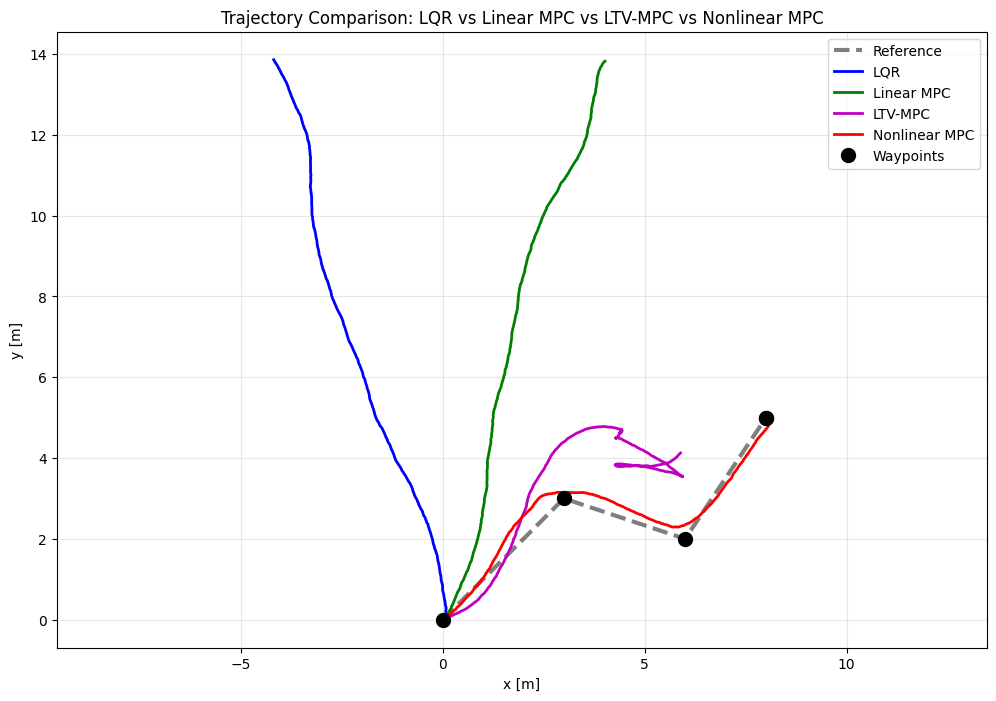

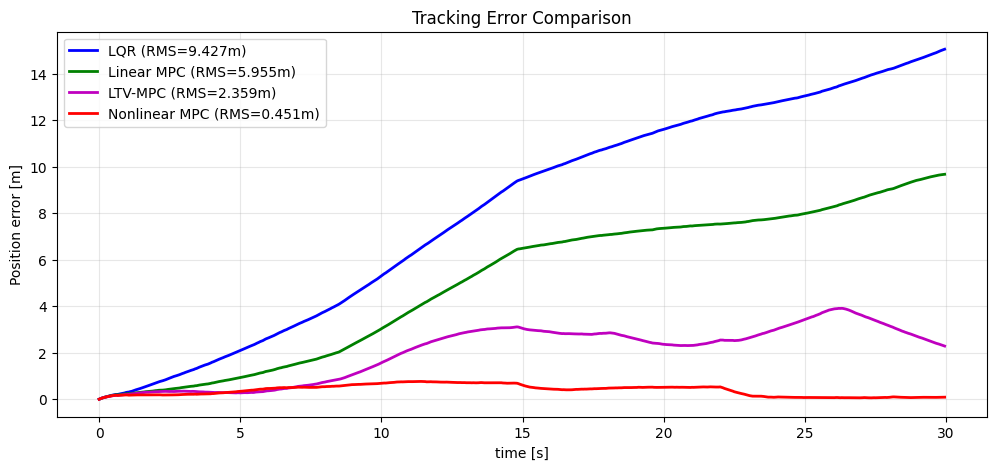

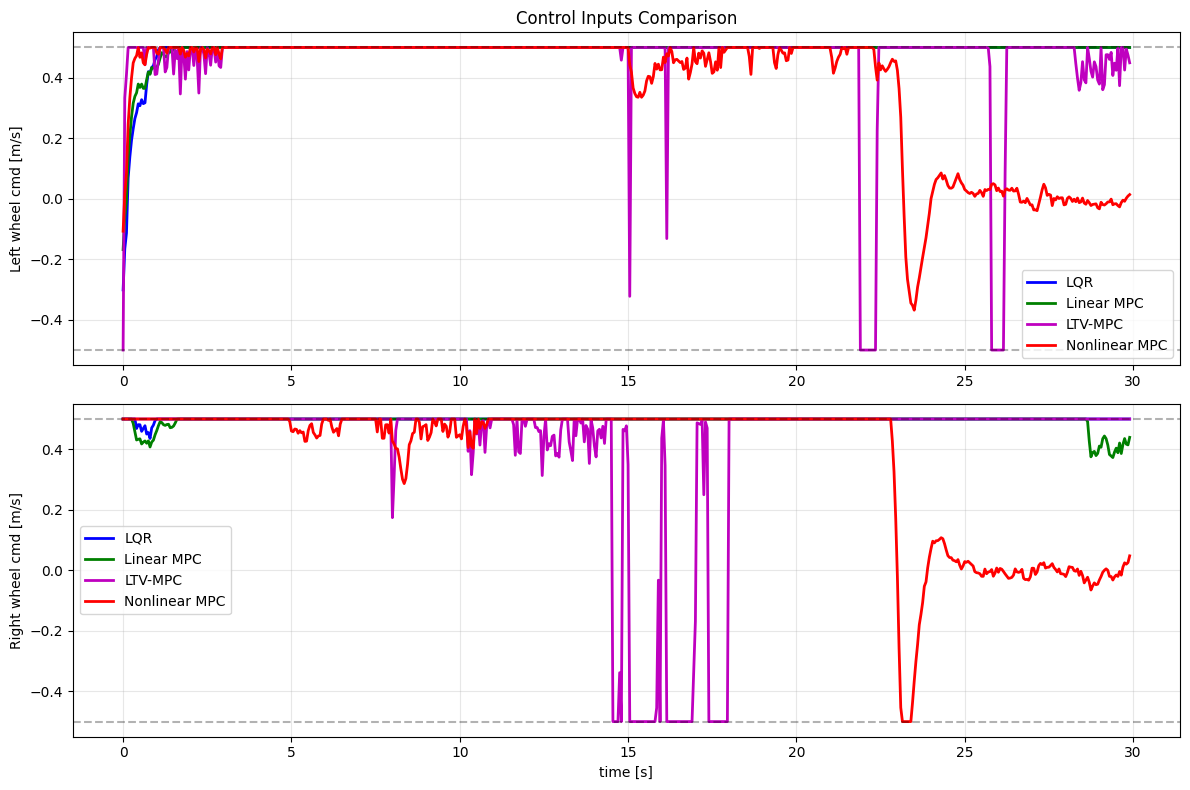


=== Performance Summary ===

LQR:
  RMS tracking error: 9.4271 m
  Max tracking error: 15.0614 m
  Mean control effort: 0.4954 m/s

Linear MPC:
  RMS tracking error: 5.9553 m
  Max tracking error: 9.6795 m
  Mean control effort: 0.4928 m/s

LTV-MPC:
  RMS tracking error: 2.3586 m
  Max tracking error: 3.9111 m
  Mean control effort: 0.4898 m/s

Nonlinear MPC:
  RMS tracking error: 0.4511 m
  Max tracking error: 0.7664 m
  Mean control effort: 0.3863 m/s


In [54]:
# Compute tracking errors
error_lqr = np.sqrt((x_true_lqr[0, :] - x_ref_traj[0, :])**2 + 
                    (x_true_lqr[1, :] - x_ref_traj[1, :])**2)
error_mpc_lin = np.sqrt((x_true_mpc_lin[0, :] - x_ref_traj[0, :])**2 + 
                        (x_true_mpc_lin[1, :] - x_ref_traj[1, :])**2)
error_mpc_ltv = np.sqrt((x_true_mpc_ltv[0, :] - x_ref_traj[0, :])**2 + 
                        (x_true_mpc_ltv[1, :] - x_ref_traj[1, :])**2)
error_mpc_nl = np.sqrt((x_true_mpc_nl[0, :] - x_ref_traj[0, :])**2 + 
                       (x_true_mpc_nl[1, :] - x_ref_traj[1, :])**2)

# Plot 1: Trajectory comparison
plt.figure(figsize=(12, 8))
plt.plot(x_ref_traj[0, :], x_ref_traj[1, :], 'k--', linewidth=3, label='Reference', alpha=0.5)
plt.plot(x_true_lqr[0, :], x_true_lqr[1, :], 'b-', linewidth=2, label='LQR')
plt.plot(x_true_mpc_lin[0, :], x_true_mpc_lin[1, :], 'g-', linewidth=2, label='Linear MPC')
plt.plot(x_true_mpc_ltv[0, :], x_true_mpc_ltv[1, :], 'm-', linewidth=2, label='LTV-MPC')
plt.plot(x_true_mpc_nl[0, :], x_true_mpc_nl[1, :], 'r-', linewidth=2, label='Nonlinear MPC')
plt.plot(waypoints[:, 0], waypoints[:, 1], 'ko', markersize=10, label='Waypoints')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Trajectory Comparison: LQR vs Linear MPC vs LTV-MPC vs Nonlinear MPC')
plt.show()

# Plot 2: Tracking error over time
plt.figure(figsize=(12, 5))
plt.plot(t, error_lqr, 'b-', linewidth=2, label=f'LQR (RMS={np.sqrt(np.mean(error_lqr**2)):.3f}m)')
plt.plot(t, error_mpc_lin, 'g-', linewidth=2, label=f'Linear MPC (RMS={np.sqrt(np.mean(error_mpc_lin**2)):.3f}m)')
plt.plot(t, error_mpc_ltv, 'm-', linewidth=2, label=f'LTV-MPC (RMS={np.sqrt(np.mean(error_mpc_ltv**2)):.3f}m)')
plt.plot(t, error_mpc_nl, 'r-', linewidth=2, label=f'Nonlinear MPC (RMS={np.sqrt(np.mean(error_mpc_nl**2)):.3f}m)')
plt.xlabel('time [s]')
plt.ylabel('Position error [m]')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Tracking Error Comparison')
plt.show()

# Plot 3: Control effort comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Left wheel
axes[0].plot(t[:-1], u_lqr[:-1, 0], 'b-', linewidth=2, label='LQR')
axes[0].plot(t[:-1], u_mpc_lin[:-1, 0], 'g-', linewidth=2, label='Linear MPC')
axes[0].plot(t[:-1], u_mpc_ltv[:-1, 0], 'm-', linewidth=2, label='LTV-MPC')
axes[0].plot(t[:-1], u_mpc_nl[:-1, 0], 'r-', linewidth=2, label='Nonlinear MPC')
axes[0].axhline(u_max, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(-u_max, color='k', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Left wheel cmd [m/s]')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_title('Control Inputs Comparison')

# Right wheel
axes[1].plot(t[:-1], u_lqr[:-1, 1], 'b-', linewidth=2, label='LQR')
axes[1].plot(t[:-1], u_mpc_lin[:-1, 1], 'g-', linewidth=2, label='Linear MPC')
axes[1].plot(t[:-1], u_mpc_ltv[:-1, 1], 'm-', linewidth=2, label='LTV-MPC')
axes[1].plot(t[:-1], u_mpc_nl[:-1, 1], 'r-', linewidth=2, label='Nonlinear MPC')
axes[1].axhline(u_max, color='k', linestyle='--', alpha=0.3)
axes[1].axhline(-u_max, color='k', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Right wheel cmd [m/s]')
axes[1].set_xlabel('time [s]')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Performance Summary ===")
print(f"\nLQR:")
print(f"  RMS tracking error: {np.sqrt(np.mean(error_lqr**2)):.4f} m")
print(f"  Max tracking error: {np.max(error_lqr):.4f} m")
print(f"  Mean control effort: {np.mean(np.abs(u_lqr)):.4f} m/s")

print(f"\nLinear MPC:")
print(f"  RMS tracking error: {np.sqrt(np.mean(error_mpc_lin**2)):.4f} m")
print(f"  Max tracking error: {np.max(error_mpc_lin):.4f} m")
print(f"  Mean control effort: {np.mean(np.abs(u_mpc_lin)):.4f} m/s")

print(f"\nLTV-MPC:")
print(f"  RMS tracking error: {np.sqrt(np.mean(error_mpc_ltv**2)):.4f} m")
print(f"  Max tracking error: {np.max(error_mpc_ltv):.4f} m")
print(f"  Mean control effort: {np.mean(np.abs(u_mpc_ltv)):.4f} m/s")

print(f"\nNonlinear MPC:")
print(f"  RMS tracking error: {np.sqrt(np.mean(error_mpc_nl**2)):.4f} m")
print(f"  Max tracking error: {np.max(error_mpc_nl):.4f} m")
print(f"  Mean control effort: {np.mean(np.abs(u_mpc_nl)):.4f} m/s")

## Analysis

### Implementation Details

This implementation includes several important fixes for robust MPC performance:

#### 1. **Heading Angle Wrapping** ✅

The heading angle $\theta$ wraps around at $\pm\pi$. Without proper handling, a small physical rotation can appear as a huge error:

```
Robot at θ = 3.1 rad, Reference θ = -3.1 rad
Naive error: 3.1 - (-3.1) = 6.2 rad  ← WRONG (almost 2π!)
Wrapped error: -0.08 rad  ← CORRECT (small rotation)
```

The `state_error()` function wraps the heading component:
```python
error[2] = (error[2] + π) % (2π) - π  # Always in [-π, π]
```

#### 2. **Warm-Start Initialization** ✅

Instead of starting optimization from zero controls (which often leads to poor local minima), we initialize with the reference wheel velocities:

```python
u0[k] = x_ref_horizon[3:5, k]  # Use [v_l_ref, v_r_ref] as initial guess
```

This gives the optimizer a reasonable starting point near the expected solution.

#### 3. **Correct Reference Horizon** ✅

The cost function includes a terminal cost at step $N_h$, so we need $N_h + 1$ reference points (indices 0 through $N_h$). The simulation loops now correctly extract:

```python
x_ref_horizon = x_ref_traj[:, k:k + N_horizon + 1]  # N_horizon+1 points
```

---

### Expected Performance

With these fixes, you should see:

| Controller | Expected RMS Error | Notes |
|------------|-------------------|-------|
| LQR | 0.3 - 0.5 m | No preview, reactive only |
| Linear MPC | 0.2 - 0.4 m | Preview helps anticipate turns |
| Nonlinear MPC | 0.15 - 0.3 m | Best model accuracy |

### Remaining Limitations

1. **Linearization point**: Linear MPC still uses a fixed linearization, which degrades accuracy during large heading changes

2. **Local minima**: Nonlinear MPC may occasionally find suboptimal solutions despite warm-starting

3. **Computational cost**: Nonlinear MPC is ~10x slower than Linear MPC due to repeated dynamics evaluations

---

## Theoretical Background

### When MPC Works Well

MPC excels when:
- You have an accurate dynamics model
- The optimization problem is well-conditioned
- Constraints are important
- Preview information is valuable

### Key Tuning Parameters

| Parameter | Effect of Increasing |
|-----------|---------------------|
| $Q$ (state weight) | More aggressive tracking, may oscillate |
| $R$ (control weight) | Smoother control, slower response |
| $Q_f$ (terminal weight) | Better stability, may cause overshoot |
| $N_h$ (prediction horizon) | Better anticipation, more computation |
| $N_c$ (control horizon) | More flexibility, harder optimization |

### Further Reading

- Boyd & Vandenberghe, *Convex Optimization* (for QP-based MPC)
- Rawlings & Mayne, *Model Predictive Control: Theory and Design*
- Borrelli et al., *Predictive Control for Linear and Hybrid Systems*